In [4]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

seed = 42

### Classical Features

In [5]:
def load_haralick_features():
    data = pd.read_csv(f"haralick.csv", index_col=0)
    labels = data.pop("y")
    return data, labels

In [6]:
def load_features():
    data, labels = [], []
    for sbj in range(100):
        if sbj % 10 == 9:
            print(f"{sbj + 1} / 100 patients loaded")

        if os.path.exists(f"{DATA_PATH}/CLASS1_MALIGNANT/LCp{sbj:04}_biobank"):
            label = "CLASS1_MALIGNANT"
        elif os.path.exists(f"{DATA_PATH}/CLASS2_BENIGN/LCp{sbj:04}_biobank"):
            label = "CLASS2_BENIGN"
        else:
            continue

        print(f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}")

        pet = nib.load(
            f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_PT_partition.nii"
        )
        ct = nib.load(
            f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_CT_partition.nii"
        )

        pet_res = pet.header["pixdim"][1:4]
        ct_res = ct.header["pixdim"][1:4]

        pet_scan = np.array(pet.dataobj)
        ct_scan = np.array(ct.dataobj)

        pet_mask = np.array(
            nib.load(
                f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_PT_mask.nii"
            ).dataobj
        )
        ct_mask = np.array(
            nib.load(
                f"{DATA_PATH}/{label}/LCp{sbj:04}_biobank/LCp{sbj:04}_CT_mask.nii"
            ).dataobj
        )

        # Calculate patient features
        pet_vol = pet_res.prod() * pet_mask.sum()
        ct_vol = ct_res.prod() * ct_mask.sum()
        mean_glucose = pet_scan[pet_mask != 0].mean()
        data.append((pet_vol, ct_vol, mean_glucose))
        labels.append(1 if label == "CLASS1_MALIGNANT" else 0)

    return np.array(data), np.array(labels)


In [7]:
data, labels = load_haralick_features()
data

,original_glcm_Autocorrelation,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_glcm_ClusterTendency,original_glcm_Contrast,original_glcm_Correlation,original_glcm_DifferenceAverage,original_glcm_DifferenceEntropy,original_glcm_DifferenceVariance,original_glcm_Id,...,original_glcm_Imc2,original_glcm_InverseVariance,original_glcm_JointAverage,original_glcm_JointEnergy,original_glcm_JointEntropy,original_glcm_MCC,original_glcm_MaximumProbability,original_glcm_SumAverage,original_glcm_SumEntropy,original_glcm_SumSquares
0,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,-3.203427e-16,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,-3.203427e-16,1.000000,1.000000,2.000000,-3.203427e-16,0.000000
1,276.389664,8.519291e+03,-236.394185,57.277441,23.209608,0.411545,3.588747,3.219321e+00,8.666041,0.364567,...,0.740591,0.268240,16.363306,0.008151,7.478332e+00,0.476557,0.026394,32.726612,4.767019e+00,20.121762
2,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,-3.203427e-16,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,-3.203427e-16,1.000000,1.000000,2.000000,-3.203427e-16,0.000000
3,106.206222,2.391478e+02,-22.500014,6.424266,2.893222,0.371838,1.163500,2.034986e+00,1.520185,0.602747,...,0.493577,0.447635,10.262562,0.069975,4.655313e+00,0.411430,0.180815,20.525125,3.167033e+00,2.329372
4,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,-3.203427e-16,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,-3.203427e-16,1.000000,1.000000,2.000000,-3.203427e-16,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,669.515907,2.816160e+04,-936.035214,67.098914,20.692854,0.515699,2.883921,3.066245e+00,11.507501,0.461716,...,0.687982,0.334384,25.648240,0.024774,6.808630e+00,0.591413,0.078901,51.296480,4.515170e+00,21.947942
116,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,-3.203427e-16,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,-3.203427e-16,1.000000,1.000000,2.000000,-3.203427e-16,0.000000
117,255.284665,4.104076e+02,-25.504637,6.656902,3.348914,0.318779,1.164550,1.979078e+00,1.868679,0.612233,...,0.460863,0.451702,15.951690,0.069955,4.684613e+00,0.391474,0.146813,31.903381,3.187460e+00,2.501454
118,1.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,-3.203427e-16,0.000000,1.000000,...,0.000000,0.000000,1.000000,1.000000,-3.203427e-16,1.000000,1.000000,2.000000,-3.203427e-16,0.000000


In [8]:
data.dtypes

original_glcm_Autocorrelation       float64
original_glcm_ClusterProminence     float64
original_glcm_ClusterShade          float64
original_glcm_ClusterTendency       float64
original_glcm_Contrast              float64
original_glcm_Correlation           float64
original_glcm_DifferenceAverage     float64
original_glcm_DifferenceEntropy     float64
original_glcm_DifferenceVariance    float64
original_glcm_Id                    float64
original_glcm_Idm                   float64
original_glcm_Idmn                  float64
original_glcm_Idn                   float64
original_glcm_Imc1                  float64
original_glcm_Imc2                  float64
original_glcm_InverseVariance       float64
original_glcm_JointAverage          float64
original_glcm_JointEnergy           float64
original_glcm_JointEntropy          float64
original_glcm_MCC                   float64
original_glcm_MaximumProbability    float64
original_glcm_SumAverage            float64
original_glcm_SumEntropy        

## Scikit-Learn

In [9]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC


In [10]:
def print_metrics(y_true, y_pred, model_name) -> None:
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print(model_name)
    print(f"Sensitivity: {tp / (tp + fn) * 100:.1f}%")
    print(f"Specificity: {tn / (tn + fp) * 100:.1f}%")
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.1f}%")
    print(f"ROC-AUC: {roc_auc_score(y_true, y_pred) * 100:.1f}%")

    plt.imshow(cm, cmap=mpl.colormaps["Blues"])
    plt.colorbar()
    plt.title("Confusion matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0, 1], ["negative", "positive"])
    plt.yticks([0, 1], ["negative", "positive"])
    for (j, i), label in np.ndenumerate(cm):
        color = "darkblue" if label < cm.max() / 2 else "white"
        plt.text(i, j, label, color=color)
    plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=seed
)

svc_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        # ("pca", PCA(0.9)),
        ("svc", SVC(kernel="linear", random_state=seed)),
    ]
)
rf_pipe = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        # ("pca", PCA(0.9)),
        ("rf", RandomForestClassifier(criterion="entropy", random_state=seed)),
    ]
)

SVC

Linear SVC
Sensitivity: 64.3%
Specificity: 90.0%
Accuracy: 75.0%
ROC-AUC: 77.1%


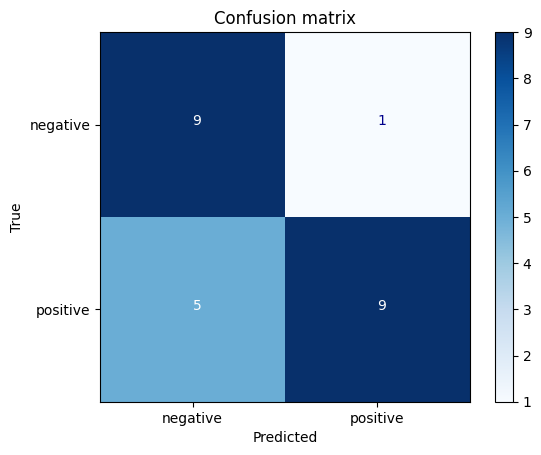

In [12]:
svc_pipe.fit(X_train, y_train)
y_pred = svc_pipe.predict(X_test)
print_metrics(y_test, y_pred, "Linear SVC")

Random Forest

Random Forest
Sensitivity: 64.3%
Specificity: 90.0%
Accuracy: 75.0%
ROC-AUC: 77.1%


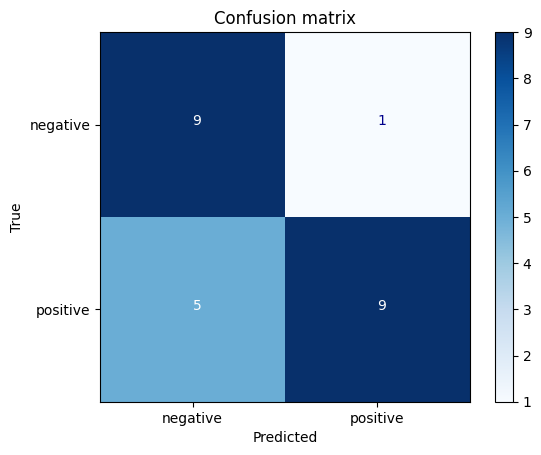

In [13]:
rf_pipe.fit(X_train, y_train)
y_pred = rf_pipe.predict(X_test)
print_metrics(y_test, y_pred, "Random Forest")